# **Keras và Neptune**
> Tương tự như fastai, chúng ta sẽ cùng thử với một vài phương pháp train dữ liệu như:
> 1. Progressive Resize
> 2. LabelSmooth
> 3. MixUP

Chúng ta sẽ cùng sử dụng wandb để log lại metrics, lr, weights và các thông số khác.

In [ ]:
import tensorflow as tf
from tensorflow import keras as keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental import preprocessing as PreprocessingLayers
from tensorflow.keras import backend as bk
import numpy as np
import math
from neptune.new.integrations.tensorflow_keras import NeptuneCallback
import neptune.new as neptune
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
# Kiểm tra GPU:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# Kiểm tra tensorflow & keras version:
tf.__version__, keras.__version__

('2.6.0', '2.6.0')

In [ ]:
# Tạo path dữ liệu:
path = '../data'
!ls {path}

test  train


# Giới hạn GPU

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [ ]:
!nvidia-smi

Tue Sep 21 14:06:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.01    Driver Version: 471.41       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| 39%   42C    P8    16W / 180W |   1402MiB /  8192MiB |    ERR!      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Tạo dữ liệu

In [ ]:
# Tạo dữ liệu
def create_raw_ds():
    bs = 32
    seed = 42
    train_ds = image_dataset_from_directory(
        f'{path}/train/'
        , labels='inferred'
        , label_mode='binary'
        , batch_size=bs
        , image_size=(460, 460)
        , seed=seed
        , validation_split=.2
        , subset='training'
    )

    valid_ds = image_dataset_from_directory(
        f'{path}/train/'
        , labels='inferred'
        , label_mode='binary'
        , batch_size=bs
        , image_size=(460, 460)
        , seed=seed
        , validation_split=.2
        , subset='validation'
    )
    return train_ds, valid_ds

In [ ]:
# Tạo preprocessing layer:
def create_preprocessed_ds(dataset, size):
    preprocessing_layer = keras.Sequential([
        PreprocessingLayers.RandomCrop(size, size, seed=42),
        PreprocessingLayers.RandomContrast([.5, 1.5]),
        PreprocessingLayers.RandomFlip(),
        keras.layers.Lambda(lambda x: keras.applications.resnet.preprocess_input(x))
    ])

    def preprocess_images(image, label):
        image = preprocessing_layer(image)
        return image, label
    
    dataset = dataset.map(preprocess_images)
    dataset = dataset.cache().prefetch(tf.data.AUTOTUNE)
    return dataset

In [ ]:
def f1(y_true, y_pred):
    # Tính True Positive:
    TP = bk.sum(bk.round(bk.clip(y_true * y_pred, 0, 1)))
    
    # Tính Actual Positve: TP + FN
    TP_FN = bk.sum(bk.round(bk.clip(y_true, 0, 1)))
    
    # Tính Predicted Positve: TP + FP
    TP_FP = bk.sum(bk.round(bk.clip(y_pred, 0, 1)))
    
    return  (2 * TP)/(TP_FN + TP_FP + bk.epsilon())

In [ ]:
# Tạo hàm tạo model:
def create_model(size: int, num_classes: int=1):
    activation = 'sigmoid'
    if num_classes > 2: activation='softmax'
    resnet_model = keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_shape=(size, size, 3))
    for layer in resnet_model.layers:
        layer.trainable=False
    
    flatten = keras.layers.Flatten()(resnet_model.output)
    # Bổ sung dropout layer:
    dropout = keras.layers.Dropout(.5)(flatten)
    prediction = keras.layers.Dense(num_classes, activation=activation)(dropout)
    return keras.models.Model(inputs=resnet_model.input, outputs=prediction)

# Bắt đầu neptune
> Khác với wandb (Weights & Biases), trước khi bạn bắt đầu project, bạn cần phải login bằng comnand line `wandb login`, với neptune, bạn không cần phải làm vậy mà chỉ cần init project là được. Khi bạn init project, neptune sẽ tự động login vào project của bạn thông qua API token đã được lưu ở path và bạn chỉ cần init project trên python mà thôi.


In [ ]:
# Tạo tên của Namespace và project
PROJECT_NAME = 'keras-swift-swallow'
NAMESPACE = 'ddpham'
SEED = 42

# Progressive Resize
> Chúng ta sẽ thử với 3 size khác nhau: 128, 224 và 256. Với mỗi inputshape này, chúng ta sẽ phải tạo mới model, tuy nhiên, sẽ update weights của layer cuối cùng từ model cũ.

## SIZE 128

In [ ]:
RUN_ID = 'KERAS-1' # bạn có thể 
RUN_NAME = 'keras-pr1'
DESC = 'Run progressive resize for 128, 224 and 256'
TAG = 'ProgressiveResize'
# run = neptune.init(project=f'{NAMESPACE}/{PROJECT_NAME}', name=RUN_NAME, description=DESC, tags=TAG) # Cho lần khởi tạo run đầu tiên
run = neptune.init(project=f'{NAMESPACE}/{PROJECT_NAME}', run=RUN_ID) # Cho lần chạy lại sau

https://app.neptune.ai/ddpham/keras-swift-swallow/e/KERAS-1
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


Info (NVML): Unknown Error. GPU usage metrics may not be reported. For more information, see https://docs-legacy.neptune.ai/logging-and-managing-experiment-results/logging-experiment-data.html#hardware-consumption 


In [ ]:
SIZE = 128
tf.random.set_seed(SEED)
train_ds, valid_ds = create_raw_ds()
train_ds = create_preprocessed_ds(train_ds, SIZE)
valid_ds = create_preprocessed_ds(valid_ds, SIZE)

Found 713 files belonging to 2 classes.
Using 571 files for training.
Found 713 files belonging to 2 classes.
Using 142 files for validation.


### Tìm lr

In [ ]:
def record_lr(model, epoch, train_ds, valid_ds):
    lr_scheduler = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * (10 ** (epoch/5)))
    optimizer = keras.optimizers.Adam(learning_rate=1e-8)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', f1])
    model.fit(train_ds, epochs=epoch, validation_data=valid_ds, callbacks=[lr_scheduler])

In [ ]:
bk.clear_session()
tf.random.set_seed(SEED)
model = create_model(SIZE, 1)
record_lr(model, 40, train_ds, valid_ds)

Epoch 1/40
18/18 [==============================] - 14s 257ms/step - loss: 1.9302 - accuracy: 0.4746 - f1: 0.4981 - val_loss: 1.1534 - val_accuracy: 0.4789 - val_f1: 0.5441
Epoch 2/40
18/18 [==============================] - 1s 66ms/step - loss: 2.0109 - accuracy: 0.4676 - f1: 0.5037 - val_loss: 1.1533 - val_accuracy: 0.4789 - val_f1: 0.5441
Epoch 3/40
18/18 [==============================] - 1s 68ms/step - loss: 1.9919 - accuracy: 0.4869 - f1: 0.5285 - val_loss: 1.1532 - val_accuracy: 0.4789 - val_f1: 0.5441
Epoch 4/40
18/18 [==============================] - 1s 68ms/step - loss: 1.9477 - accuracy: 0.4746 - f1: 0.5282 - val_loss: 1.1530 - val_accuracy: 0.4789 - val_f1: 0.5441
Epoch 5/40
18/18 [==============================] - 1s 74ms/step - loss: 1.9653 - accuracy: 0.4851 - f1: 0.5333 - val_loss: 1.1527 - val_accuracy: 0.4789 - val_f1: 0.5441
Epoch 6/40
18/18 [==============================] - 1s 67ms/step - loss: 2.0091 - accuracy: 0.4729 - f1: 0.5227 - val_loss: 1.1523 - val_accura

In [ ]:
def plot_lr(history):
    plt.figure(figsize=(8,4))
    plt.semilogx(history["lr"], history["val_loss"])
    plt.axis([1e-8, 1e-1, 0, 2])
    plt.show()

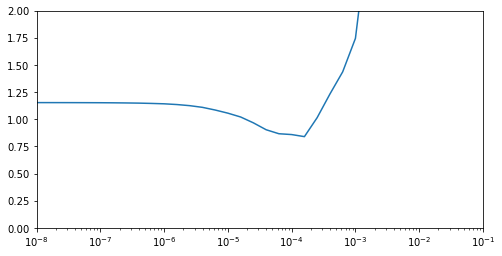

In [ ]:
plot_lr(model.history.history)

In [ ]:
def find_lr(history):
    lr_list = history['lr']
    loss_list = history['loss']
    empty_dict = {}
    for i in range(len(lr_list)):
        if (loss_list[i] <= 2) & (lr_list[i] <= 1e-1) & (i >= 1):
            empty_dict.update({lr_list[i]: loss_list[i-1] - loss_list[i]})
    max_gap = max(empty_dict.values())
    best_lr = 0
    for key in empty_dict.keys():
        if empty_dict[key] == max_gap: 
            print("max_lr =", key)
            best_lr = key
    return empty_dict, best_lr

In [ ]:
lr_list, best_lr = find_lr(model.history.history)
lr_list

max_lr = 0.00015848932


{2.5118863e-08: 0.018999218940734863,
 3.981072e-08: 0.044141173362731934,
 6.309573e-08: -0.017589449882507324,
 1.5848931e-07: 0.10344243049621582,
 6.3095735e-07: 0.014651894569396973,
 1e-06: 0.03699755668640137,
 1.5848932e-06: -0.007026791572570801,
 2.5118864e-06: 0.05487048625946045,
 6.3095736e-06: 0.12708652019500732,
 1e-05: 0.25294339656829834,
 1.5848931e-05: -0.12592363357543945,
 2.5118865e-05: 0.2628690004348755,
 3.981072e-05: 0.06074965000152588,
 6.309574e-05: 0.06859862804412842,
 1e-04: 0.2892059087753296,
 0.00015848932: 0.3481373190879822,
 0.00025118864: 0.12683308124542236,
 0.00039810716: 0.21272847056388855,
 0.00063095737: -0.1592121422290802,
 0.001: 0.3421366810798645,
 0.0015848932: -0.08078330755233765,
 0.0025118864: 0.036077022552490234,
 0.0039810715: -0.005272597074508667,
 0.0063095735: -1.050049215555191}

### Bắt đầu lại

In [ ]:
def lr_cycle(epoch, max_lr):
    stepsize = 4
    epsilon = math.log(10, stepsize)
    remainder = epoch % (stepsize * 2)
    if (stepsize + 1) <= remainder: new_lr = max_lr * (epsilon ** (remainder - stepsize - 1))
    else: new_lr = max_lr / (epsilon ** (remainder - stepsize - 1))
    return new_lr

In [ ]:
max_lr = best_lr
model = create_model(SIZE, 1)
lr_scheduler = keras.callbacks.LearningRateScheduler(lambda epoch: lr_cycle(epoch, max_lr))
optimizer = keras.optimizers.Adam(learning_rate=max_lr/10)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', f1])
epochs = 24
model.fit(train_ds, epochs=epochs, validation_data=valid_ds, callbacks=[lr_scheduler, NeptuneCallback(run=run)])

Epoch 1/24
18/18 [==============================] - 5s 120ms/step - loss: 3.4179 - accuracy: 0.6252 - f1: 0.6377 - val_loss: 2.6571 - val_accuracy: 0.6972 - val_f1: 0.7709
Epoch 2/24
18/18 [==============================] - 1s 68ms/step - loss: 1.7878 - accuracy: 0.7986 - f1: 0.8233 - val_loss: 3.3542 - val_accuracy: 0.6549 - val_f1: 0.7600
Epoch 3/24
18/18 [==============================] - 1s 68ms/step - loss: 0.6100 - accuracy: 0.8879 - f1: 0.8994 - val_loss: 2.0515 - val_accuracy: 0.7254 - val_f1: 0.7633
Epoch 4/24
18/18 [==============================] - 1s 68ms/step - loss: 0.2714 - accuracy: 0.9335 - f1: 0.9412 - val_loss: 1.9669 - val_accuracy: 0.7676 - val_f1: 0.8077
Epoch 5/24
18/18 [==============================] - 1s 66ms/step - loss: 0.1716 - accuracy: 0.9405 - f1: 0.9482 - val_loss: 1.9384 - val_accuracy: 0.7746 - val_f1: 0.8111
Epoch 6/24
18/18 [==============================] - 1s 69ms/step - loss: 0.1394 - accuracy: 0.9580 - f1: 0.9605 - val_loss: 1.9353 - val_accurac

In [ ]:
# Lấy toàn bộ weights của layer cuối cùng (prediction)
last_layer_weights_128 = model.layers[-1].get_weights()
last_layer_weights_128

[array([[ 0.01813551],
        [-0.00840165],
        [ 0.01276074],
        ...,
        [-0.01055076],
        [-0.00253334],
        [ 0.01563301]], dtype=float32),
 array([0.00342254], dtype=float32)]

## SIZE 224

### Tạo lại dữ liệu

In [ ]:
SIZE = 224
tf.random.set_seed(SEED)
train_ds, valid_ds = create_raw_ds()
train_ds = create_preprocessed_ds(train_ds, SIZE)
valid_ds = create_preprocessed_ds(valid_ds, SIZE)

Found 713 files belonging to 2 classes.
Using 571 files for training.
Found 713 files belonging to 2 classes.
Using 142 files for validation.


### Cập nhật model
> Chúng ta cần cập nhật layer cuối cùng của model mới, dựa vào weights của model cũ.

In [ ]:
def update_model(model, weights):
    update_len = [len(weights[0]), len(weights[1])]
    last_weights = model.layers[-1].get_weights()
    
    # Cập nhật weights:
    for i in [0, 1]:
        np.put(last_weights[i], np.arange(update_len[i]),  weights[i])
    
    # bổ sung weights vào model:
    model.layers[-1].set_weights(last_weights)

### Tìm lr

In [ ]:
bk.clear_session()
tf.random.set_seed(SEED)
# Tạo model mới:
model = create_model(SIZE, 1)

# Cập nhật weights cho layer cuối:
update_model(model, last_layer_weights_128)

# Tìm lr:
record_lr(model, 40, train_ds, valid_ds)

Epoch 1/40
18/18 [==============================] - 12s 416ms/step - loss: 1.5924 - accuracy: 0.7233 - f1: 0.7525 - val_loss: 1.8248 - val_accuracy: 0.7394 - val_f1: 0.7790
Epoch 2/40
18/18 [==============================] - 2s 124ms/step - loss: 1.8998 - accuracy: 0.6900 - f1: 0.7203 - val_loss: 1.8248 - val_accuracy: 0.7394 - val_f1: 0.7790
Epoch 3/40
18/18 [==============================] - 2s 121ms/step - loss: 1.6395 - accuracy: 0.7233 - f1: 0.7519 - val_loss: 1.8247 - val_accuracy: 0.7394 - val_f1: 0.7790
Epoch 4/40
18/18 [==============================] - 2s 124ms/step - loss: 1.8507 - accuracy: 0.7215 - f1: 0.7449 - val_loss: 1.8247 - val_accuracy: 0.7394 - val_f1: 0.7790
Epoch 5/40
18/18 [==============================] - 2s 125ms/step - loss: 1.7565 - accuracy: 0.6988 - f1: 0.7321 - val_loss: 1.8247 - val_accuracy: 0.7394 - val_f1: 0.7790
Epoch 6/40
18/18 [==============================] - 2s 125ms/step - loss: 1.5933 - accuracy: 0.7443 - f1: 0.7693 - val_loss: 1.8246 - val_a

In [ ]:
def plot_lr(history):
    plt.figure(figsize=(8,4))
    plt.semilogx(history["lr"], history["val_loss"])
    plt.axis([1e-8, 1e-1, 0, 5])
    plt.show()

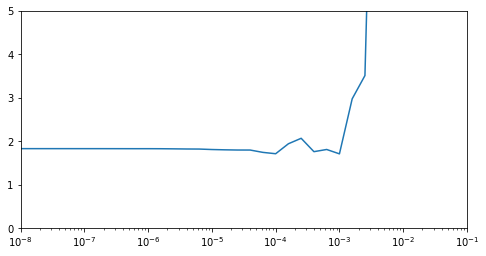

In [ ]:
plot_lr(model.history.history)

In [ ]:
lr_list, best_lr = find_lr(model.history.history)
lr_list

max_lr = 0.00039810716


{2.5118863e-08: 0.24944889545440674,
 6.3095735e-07: 0.1006631851196289,
 1e-06: -0.006995201110839844,
 3.9810716e-06: 0.2346940040588379,
 6.3095736e-06: -0.09289717674255371,
 1e-05: 0.15661323070526123,
 1.5848931e-05: -0.08330261707305908,
 2.5118865e-05: 0.1988128423690796,
 3.981072e-05: 0.2703903913497925,
 6.309574e-05: 0.3083239793777466,
 1e-04: 0.2606772780418396,
 0.00015848932: 0.3024551272392273,
 0.00025118864: 0.09623837471008301,
 0.00039810716: 0.31356504559516907,
 0.00063095737: 0.029846519231796265,
 0.001: 0.03415609896183014,
 0.0015848932: -0.06403869390487671,
 0.0025118864: -0.1119644045829773,
 0.0039810715: -0.5837075263261795}

### Bắt đầu lại

In [ ]:
max_lr = best_lr
model = create_model(SIZE, 1)
update_model(model, last_layer_weights_128)

lr_scheduler = keras.callbacks.LearningRateScheduler(lambda epoch: lr_cycle(epoch, max_lr))
optimizer = keras.optimizers.Adam(learning_rate=max_lr/10)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', f1])
epochs = 24
model.fit(train_ds, epochs=epochs, validation_data=valid_ds, callbacks=[lr_scheduler, NeptuneCallback(run=run)])

Epoch 1/24
18/18 [==============================] - 6s 184ms/step - loss: 5.8576 - accuracy: 0.7023 - f1: 0.7169 - val_loss: 7.5101 - val_accuracy: 0.7183 - val_f1: 0.6671
Epoch 2/24
18/18 [==============================] - 2s 126ms/step - loss: 2.7193 - accuracy: 0.8651 - f1: 0.8761 - val_loss: 5.2360 - val_accuracy: 0.7676 - val_f1: 0.8095
Epoch 3/24
18/18 [==============================] - 2s 128ms/step - loss: 0.4117 - accuracy: 0.9580 - f1: 0.9607 - val_loss: 4.3159 - val_accuracy: 0.8028 - val_f1: 0.8311
Epoch 4/24
18/18 [==============================] - 2s 125ms/step - loss: 0.1096 - accuracy: 0.9877 - f1: 0.9882 - val_loss: 4.2122 - val_accuracy: 0.7887 - val_f1: 0.8154
Epoch 5/24
18/18 [==============================] - 2s 125ms/step - loss: 0.0230 - accuracy: 0.9965 - f1: 0.9972 - val_loss: 4.3211 - val_accuracy: 0.7958 - val_f1: 0.8255
Epoch 6/24
18/18 [==============================] - 2s 126ms/step - loss: 0.0294 - accuracy: 0.9965 - f1: 0.9965 - val_loss: 4.3508 - val_ac

In [ ]:
last_layer_weights_224 = model.layers[len(model.layers)-1].get_weights()

## SIZE 256

### Tạo lại dữ liệu

In [ ]:
SIZE = 256
train_ds, valid_ds = create_raw_ds()
train_ds = create_preprocessed_ds(train_ds, SIZE)
valid_ds = create_preprocessed_ds(valid_ds, SIZE)

Found 713 files belonging to 2 classes.
Using 571 files for training.
Found 713 files belonging to 2 classes.
Using 142 files for validation.


### Tìm lr

In [ ]:
bk.clear_session()
# Tạo model mới:
model = create_model(SIZE, 1)

# Cập nhật weights cho layer cuối:
update_model(model, last_layer_weights_224)

# Tìm lr:
record_lr(model, 40, train_ds, valid_ds)

Epoch 1/40
18/18 [==============================] - 13s 468ms/step - loss: 3.6048 - accuracy: 0.8179 - f1: 0.8271 - val_loss: 4.1394 - val_accuracy: 0.7676 - val_f1: 0.7994
Epoch 2/40
18/18 [==============================] - 3s 150ms/step - loss: 3.7677 - accuracy: 0.8179 - f1: 0.8216 - val_loss: 4.1393 - val_accuracy: 0.7676 - val_f1: 0.7994
Epoch 3/40
18/18 [==============================] - 3s 152ms/step - loss: 3.7685 - accuracy: 0.8249 - f1: 0.8305 - val_loss: 4.1391 - val_accuracy: 0.7676 - val_f1: 0.7994
Epoch 4/40
18/18 [==============================] - 3s 151ms/step - loss: 4.1465 - accuracy: 0.7986 - f1: 0.8037 - val_loss: 4.1388 - val_accuracy: 0.7676 - val_f1: 0.7994
Epoch 5/40
18/18 [==============================] - 3s 154ms/step - loss: 3.7893 - accuracy: 0.8126 - f1: 0.8144 - val_loss: 4.1385 - val_accuracy: 0.7676 - val_f1: 0.7994
Epoch 6/40
18/18 [==============================] - 3s 150ms/step - loss: 3.6128 - accuracy: 0.8196 - f1: 0.8200 - val_loss: 4.1380 - val_a

In [ ]:
def plot_lr(history):
    plt.figure(figsize=(8,4))
    plt.semilogx(history["lr"], history["loss"])
#     plt.axis([1e-8, 1e-1, 0, 2])
    plt.show()

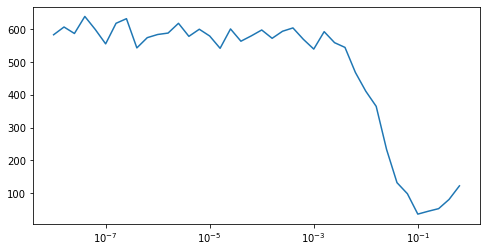

In [ ]:
plot_lr(model.history.history)

In [ ]:
def find_lr(history):
    lr_list = history['lr']
    loss_list = history['loss']
    empty_dict = {}
    for i in range(len(lr_list)):
        if (lr_list[i] <= 1e-1) & (i >= 1):
            empty_dict.update({lr_list[i]: loss_list[i-1] - loss_list[i]})
    max_gap = max(empty_dict.values())
    best_lr = 0
    for key in empty_dict.keys():
        if empty_dict[key] == max_gap: 
            print("max_lr =", key)
            best_lr = key
    return empty_dict, best_lr

In [ ]:
lr_list, best_lr = find_lr(model.history.history)
lr_list

max_lr = 0.039810717


{1.5848931e-08: -0.1629183292388916,
 2.5118863e-08: -0.0008385181427001953,
 3.981072e-08: -0.3779904842376709,
 6.309573e-08: 0.35724711418151855,
 1e-07: 0.17644953727722168,
 1.5848931e-07: -0.3007493019104004,
 2.5118865e-07: 0.29668664932250977,
 3.9810718e-07: -0.2632777690887451,
 6.3095735e-07: 0.13697409629821777,
 1e-06: -0.202470064163208,
 1.5848932e-06: 0.49144482612609863,
 2.5118864e-06: 0.04825472831726074,
 3.9810716e-06: -0.035881757736206055,
 6.3095736e-06: 0.03941941261291504,
 1e-05: 0.27951765060424805,
 1.5848931e-05: 0.15988802909851074,
 2.5118865e-05: 0.22796845436096191,
 3.981072e-05: 0.36285853385925293,
 6.309574e-05: 0.3987870216369629,
 1e-04: 0.33228158950805664,
 0.00015848932: 0.5455960035324097,
 0.00025118864: 0.36510682106018066,
 0.00039810716: 0.36923375725746155,
 0.00063095737: 0.15548068284988403,
 0.001: 0.0069524794816970825,
 0.0015848932: 0.07765641808509827,
 0.0025118864: -0.1424105018377304,
 0.0039810715: -0.46218737959861755,
 0.006

### Bắt đầu lại

In [ ]:
max_lr = best_lr
model = create_model(SIZE, 1)
update_model(model, last_layer_weights_224)

lr_scheduler = keras.callbacks.LearningRateScheduler(lambda epoch: lr_cycle(epoch, max_lr))
optimizer = keras.optimizers.Adam(learning_rate=max_lr/10)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', f1])
epochs = 8
model.fit(train_ds, epochs=epochs, validation_data=valid_ds, callbacks=[lr_scheduler, NeptuneCallback(run=run)])

Epoch 1/8
18/18 [==============================] - 11s 360ms/step - loss: 1445.2964 - accuracy: 0.6830 - f1: 0.6899 - val_loss: 1110.9489 - val_accuracy: 0.7887 - val_f1: 0.8400
Epoch 2/8
18/18 [==============================] - 3s 151ms/step - loss: 478.9771 - accuracy: 0.8809 - f1: 0.8836 - val_loss: 1105.8231 - val_accuracy: 0.8099 - val_f1: 0.8512
Epoch 3/8
18/18 [==============================] - 3s 150ms/step - loss: 65.9634 - accuracy: 0.9562 - f1: 0.9608 - val_loss: 1061.2784 - val_accuracy: 0.8099 - val_f1: 0.8494
Epoch 4/8
18/18 [==============================] - 3s 150ms/step - loss: 46.7937 - accuracy: 0.9842 - f1: 0.9869 - val_loss: 1239.9789 - val_accuracy: 0.7958 - val_f1: 0.8428
Epoch 5/8
18/18 [==============================] - 3s 150ms/step - loss: 3.8171 - accuracy: 0.9947 - f1: 0.9954 - val_loss: 1052.8729 - val_accuracy: 0.8099 - val_f1: 0.8494
Epoch 6/8
18/18 [==============================] - 3s 151ms/step - loss: 6.2269 - accuracy: 0.9965 - f1: 0.9967 - val_loss

Chúng ta có thể finish sau khi đã chạy xong.

In [ ]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 221 operations to synchronize with Neptune. Do not kill this process.


All 221 operations synced, thanks for waiting!


# Label Smooth
> Label smooth là phương pháp sử dụng callbacks của keras.

In [ ]:
RUN_ID = 'KERAS-2' # bạn có thể 
RUN_NAME = 'keras-lbs'
DESC = 'Run label smoothing technique'
TAG = 'LabelSmoothing'
run = neptune.init(project=f'{NAMESPACE}/{PROJECT_NAME}', name=RUN_NAME, description=DESC, tags=TAG) # Cho lần khởi tạo run đầu tiên
# run = neptune.init(project=f'{NAMESPACE}/{PROJECT_NAME}', run=RUN_ID) # Cho lần chạy lại sau

https://app.neptune.ai/ddpham/keras-swift-swallow/e/KERAS-2
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


## Tạo lại dữ liệu

In [ ]:
SIZE = 224
train_ds, valid_ds = create_raw_ds()
train_ds = create_preprocessed_ds(train_ds, SIZE)
valid_ds = create_preprocessed_ds(valid_ds, SIZE)

Found 713 files belonging to 2 classes.
Using 571 files for training.
Found 713 files belonging to 2 classes.
Using 142 files for validation.


## Tạo model

In [ ]:
model = create_model(SIZE, 1)
lr_scheduler = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * (10 **(epoch/5)))
optimizer = keras.optimizers.Adam(learning_rate=1e-8)
loss = keras.losses.BinaryCrossentropy(label_smoothing=.1)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy', f1])
epochs = 40
model.fit(train_ds, epochs=epochs, validation_data=valid_ds, callbacks=[lr_scheduler])

Epoch 1/40
18/18 [==============================] - 13s 418ms/step - loss: 1.5931 - accuracy: 0.5447 - f1: 0.5606 - val_loss: 1.0698 - val_accuracy: 0.5845 - val_f1: 0.6282
Epoch 2/40
18/18 [==============================] - 2s 127ms/step - loss: 1.6466 - accuracy: 0.5166 - f1: 0.5393 - val_loss: 1.0697 - val_accuracy: 0.5845 - val_f1: 0.6282
Epoch 3/40
18/18 [==============================] - 2s 124ms/step - loss: 1.6769 - accuracy: 0.4816 - f1: 0.5009 - val_loss: 1.0695 - val_accuracy: 0.5845 - val_f1: 0.6282
Epoch 4/40
18/18 [==============================] - 2s 125ms/step - loss: 1.6072 - accuracy: 0.4956 - f1: 0.5327 - val_loss: 1.0691 - val_accuracy: 0.5845 - val_f1: 0.6282
Epoch 5/40
18/18 [==============================] - 2s 133ms/step - loss: 1.5553 - accuracy: 0.5271 - f1: 0.5571 - val_loss: 1.0686 - val_accuracy: 0.5845 - val_f1: 0.6282- loss: 1.7145 - accuracy: 0.5125 - f1: - ETA: 0s - loss: 1.5737 - accuracy: 0.5257 - f1: 0.55
Epoch 6/40
18/18 [===========================

### Tìm lr

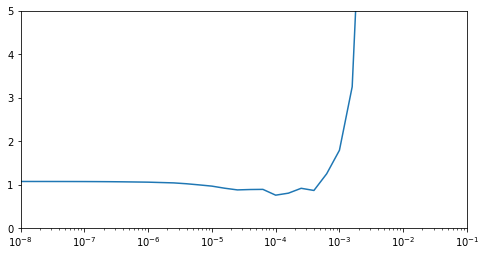

In [ ]:
plot_lr(model.history.history)

In [ ]:
lr_list, best_lr = find_lr(model.history.history)
lr_list

max_lr = 0.0063095735


{1.5848931e-08: -0.05350339412689209,
 2.5118863e-08: -0.03025686740875244,
 3.981072e-08: 0.06968379020690918,
 6.309573e-08: 0.051918745040893555,
 1e-07: 0.0005005598068237305,
 1.5848931e-07: -0.047919631004333496,
 2.5118865e-07: 0.04694008827209473,
 3.9810718e-07: 0.047373294830322266,
 6.3095735e-07: -0.0679020881652832,
 1e-06: 0.11611378192901611,
 1.5848932e-06: -0.0730212926864624,
 2.5118864e-06: 0.10423409938812256,
 3.9810716e-06: 0.08631491661071777,
 6.3095736e-06: 0.0020384788513183594,
 1e-05: 0.07646214962005615,
 1.5848931e-05: 0.05343914031982422,
 2.5118865e-05: 0.15845787525177002,
 3.981072e-05: 0.19542831182479858,
 6.309574e-05: 0.10763180255889893,
 1e-04: 0.1579785943031311,
 0.00015848932: 0.0843210220336914,
 0.00025118864: -0.01692938804626465,
 0.00039810716: 0.035379618406295776,
 0.00063095737: -0.07178106904029846,
 0.001: -0.26418793201446533,
 0.0015848932: -1.176646888256073,
 0.0025118864: -2.868919610977173,
 0.0039810715: -6.638409614562988,
 0

### Bắt đầu lại

In [ ]:
max_lr = best_lr
model = create_model(SIZE, 1)
lr_scheduler = keras.callbacks.LearningRateScheduler(lambda epoch: lr_cycle(epoch, max_lr))
optimizer = keras.optimizers.Adam(learning_rate=max_lr/10)
loss = keras.losses.BinaryCrossentropy(label_smoothing=.1)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy', f1])
epochs = 80
model.fit(train_ds, epochs=epochs, validation_data=valid_ds, callbacks=[lr_scheduler, NeptuneCallback(run=run)])

Epoch 1/80
18/18 [==============================] - 6s 181ms/step - loss: 339.1748 - accuracy: 0.6287 - f1: 0.6473 - val_loss: 277.5225 - val_accuracy: 0.7113 - val_f1: 0.6857
Epoch 2/80
18/18 [==============================] - 2s 131ms/step - loss: 181.7411 - accuracy: 0.8511 - f1: 0.8552 - val_loss: 193.2359 - val_accuracy: 0.7958 - val_f1: 0.8353
Epoch 3/80
18/18 [==============================] - 2s 126ms/step - loss: 99.6046 - accuracy: 0.9335 - f1: 0.9391 - val_loss: 178.6690 - val_accuracy: 0.7746 - val_f1: 0.8121
Epoch 4/80
18/18 [==============================] - 2s 127ms/step - loss: 101.5809 - accuracy: 0.9335 - f1: 0.9424 - val_loss: 162.1797 - val_accuracy: 0.8028 - val_f1: 0.8084
Epoch 5/80
18/18 [==============================] - 2s 128ms/step - loss: 79.8643 - accuracy: 0.9860 - f1: 0.9858 - val_loss: 138.7579 - val_accuracy: 0.8099 - val_f1: 0.8279loss: 85.4460 - accuracy: 0.9880 - f1: 0.98 - ETA: 0s - loss: 84.5190 - accuracy: 0.9888 - 
Epoch 6/80
18/18 [=============

label_smoothing hiện đang cho kết quả tốt nhất ở đây.

In [ ]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 210 operations to synchronize with Neptune. Do not kill this process.


All 210 operations synced, thanks for waiting!


# MixUp
> Chúng ta sẽ thực hiện Mixup dựa trên ý tưởng và code từ đây : https://keras.io/examples/vision/mixup/

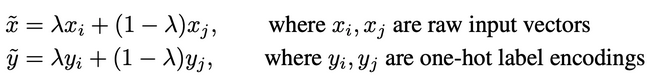
>
> Tuy nhiên, phần tạo ra lambda, chúng ta sẽ thực hiện đơn giản hơn dưới dạng input giá trị từ 0-1 mà thôi. Phần giá trị của lambda cần theo Beta distribution sẽ được thực hiện sau

## Tạo preprocessing layer
> Với phương pháp MixUp, chúng ta sẽ thực hiện MixUp trước, sau đó sẽ dùng CentralCrop, Rescale & Normalize.

In [ ]:
RUN_ID = 'KERAS-4' # bạn có thể 
RUN_NAME = 'keras-mixup'
DESC = 'Run mixup technique'
TAG = 'MixUp'
# run = neptune.init(project=f'{NAMESPACE}/{PROJECT_NAME}', name=RUN_NAME, description=DESC, tags=TAG) # Cho lần khởi tạo run đầu tiên
run = neptune.init(project=f'{NAMESPACE}/{PROJECT_NAME}', run=RUN_ID) # Cho lần chạy lại sau

https://app.neptune.ai/ddpham/keras-swift-swallow/e/KERAS-4
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [ ]:
# tạo dữ liệu
SIZE = 224
train_ds, valid_ds = create_raw_ds()

Found 713 files belonging to 2 classes.
Using 571 files for training.
Found 713 files belonging to 2 classes.
Using 142 files for validation.


In [ ]:
# Tạo dữ liệu cho mixup
train_ds_dup = tf.data.Dataset.zip((train_ds, train_ds))

In [ ]:
# Tạo lại preprocess layer
def create_preprocessed_ds(dataset, size):
    preprocessing_layer = keras.Sequential([
        PreprocessingLayers.CenterCrop(size, size),
        keras.layers.Lambda(lambda x: keras.applications.resnet.preprocess_input(x))
    ])

    def preprocess_images(image, label):
        image = preprocessing_layer(image)
        return image, label
    
    return dataset.map(preprocess_images).cache().prefetch(tf.data.AUTOTUNE)

## Tạo Mixup
> idea của tạo MixUp là chúng ta sẽ duplicate dữ liệu tập train thành 2 training sets, với các ảnh đã được xóa trộn (shufffle), sau đó, chúng ta sẽ merge 2 tập lại với nhau theo tỷ lệ lambda. Và chúng ta sẽ được một tập train mới tương đồng về số lượng ảnh như tập ban đầu, nhưng ảnh đã được "mixed up" vs nhau.

In [ ]:
def mix_up(ds_one, ds_two, l: float=.2):
    # Tách dữ liệu ảnh và label của 2 batch:
    images_one, labels_one = ds_one
    images_two, labels_two = ds_two
    batch_size = tf.shape(images_one)[0]

    # Tạo X, y:
    x_l = tf.reshape(tf.ones((batch_size, 1)) * l, (batch_size, 1, 1, 1))
    y_l = tf.reshape(tf.ones((batch_size, 1)) * l, (batch_size, 1))

    # Thực hiện mixup giữa 2 batch, tỷ lệ 1:1
    images = images_one * x_l + images_two * (1 - x_l)
    labels = labels_one * y_l + labels_two * (1 - y_l)
    return (images, labels)

In [ ]:
# Tạo dữ liệu mix up:
train_ds_dup = train_ds_dup.map(lambda ds_one, ds_two: mix_up(ds_one, ds_two, l=.2), num_parallel_calls=tf.data.AUTOTUNE)
train_ds_dup

<ParallelMapDataset shapes: ((None, 460, 460, 3), (None, 1)), types: (tf.float32, tf.float32)>

/home/ddpham/miniconda3/envs/tf/lib/python3.8/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


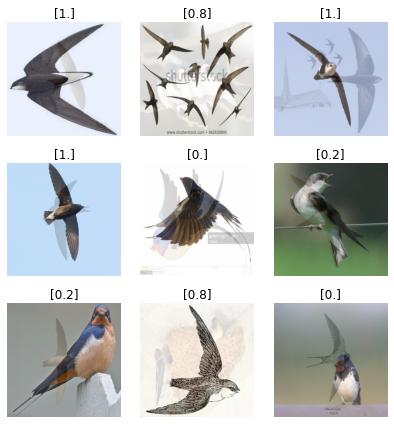

In [ ]:
plt.figure(figsize=(6,6))
for image in train_ds_dup.as_numpy_iterator():
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(image[0][i]/255.)
        plt.title(image[1][i])
        plt.axis("off")
        plt.tight_layout()
    break

In [ ]:
# Biến đổi dữ liệu cuối cùng
train_ds_dup = create_preprocessed_ds(train_ds_dup, SIZE)
valid_ds = create_preprocessed_ds(valid_ds, SIZE)

In [ ]:
train_ds_dup = train_ds_dup.cache().prefetch(tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(tf.data.AUTOTUNE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


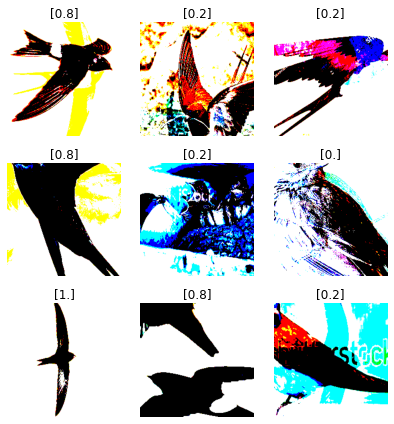

In [ ]:
# Kiểm tra lại dữ liệu:
plt.figure(figsize=(6,6))
for image in train_ds_dup.as_numpy_iterator():
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(image[0][i])
        plt.title(image[1][i])
        plt.axis("off")
        plt.tight_layout()
    break

## Tìm lr

In [ ]:
bk.clear_session()
model = create_model(SIZE, 1)
record_lr(model, 40, train_ds_dup, valid_ds)

Epoch 1/40
18/18 [==============================] - 11s 318ms/step - loss: 2.0863 - accuracy: 0.2172 - f1: 0.3339 - val_loss: 1.7263 - val_accuracy: 0.4366 - val_f1: 0.1743
Epoch 2/40
18/18 [==============================] - 2s 130ms/step - loss: 2.1074 - accuracy: 0.1961 - f1: 0.3119 - val_loss: 1.7234 - val_accuracy: 0.4296 - val_f1: 0.1701oss: 2.1758 - accuracy: 0.1910 - f1 - ETA: 0s - loss: 2.1192 - accuracy: 0.1967 - f1: 0.31
Epoch 3/40
18/18 [==============================] - 2s 123ms/step - loss: 2.1056 - accuracy: 0.2084 - f1: 0.3100 - val_loss: 1.7187 - val_accuracy: 0.4155 - val_f1: 0.1685
Epoch 4/40
18/18 [==============================] - 2s 125ms/step - loss: 1.9242 - accuracy: 0.2434 - f1: 0.3656 - val_loss: 1.7111 - val_accuracy: 0.4225 - val_f1: 0.1838
Epoch 5/40
18/18 [==============================] - 2s 127ms/step - loss: 2.0207 - accuracy: 0.2277 - f1: 0.3034 - val_loss: 1.6996 - val_accuracy: 0.4225 - val_f1: 0.1838
Epoch 6/40
18/18 [==============================]

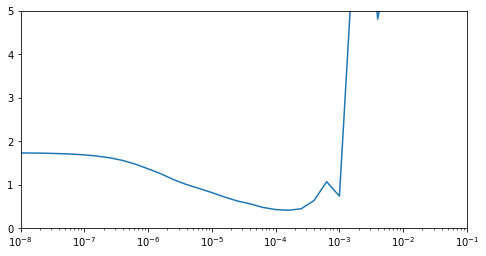

In [ ]:
plot_lr(model.history.history)

In [ ]:
lr_list, best_lr = find_lr(model.history.history)
lr_list

max_lr = 6.3095736e-06


{1.5848931e-08: 0.13715600967407227,
 2.5118863e-08: -0.1323709487915039,
 3.981072e-08: 0.05991780757904053,
 6.309573e-08: -0.05971252918243408,
 1e-07: 0.0712728500366211,
 1.5848931e-07: 0.030665874481201172,
 2.5118865e-07: -0.014341592788696289,
 3.9810718e-07: 0.016941070556640625,
 6.3095735e-07: -0.052091240882873535,
 1e-06: 0.10325944423675537,
 1.5848932e-06: 0.022492408752441406,
 2.5118864e-06: 0.019550204277038574,
 3.9810716e-06: 0.09325742721557617,
 6.3095736e-06: 0.24327993392944336,
 1e-05: 0.08611094951629639,
 1.5848931e-05: 0.07125222682952881,
 2.5118865e-05: 0.04884755611419678,
 3.981072e-05: 0.2224225401878357,
 6.309574e-05: 0.14191418886184692,
 1e-04: 0.10955184698104858,
 0.00015848932: -0.0025777816772460938,
 0.00025118864: 0.06742870807647705,
 0.00039810716: -0.05904155969619751,
 0.00063095737: -0.10962152481079102,
 0.001: -0.40962183475494385}

## Bắt đầu lại

In [ ]:
max_lr = best_lr
model = create_model(224, 1)
lr_scheduler = keras.callbacks.LearningRateScheduler(lambda epoch: lr_cycle(epoch, max_lr))
optimizer = keras.optimizers.Adam(learning_rate=max_lr/10)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', f1])
epochs = 43
model.fit(train_ds_dup, epochs=epochs, validation_data=valid_ds, callbacks=[lr_scheduler, NeptuneCallback(run=run)])

Epoch 1/43
18/18 [==============================] - 6s 181ms/step - loss: 151.5031 - accuracy: 0.3800 - f1: 0.7267 - val_loss: 99.1707 - val_accuracy: 0.7394 - val_f1: 0.7501
Epoch 2/43
18/18 [==============================] - 2s 126ms/step - loss: 174.6921 - accuracy: 0.4816 - f1: 0.8336 - val_loss: 119.8809 - val_accuracy: 0.7606 - val_f1: 0.8280
Epoch 3/43
18/18 [==============================] - 2s 127ms/step - loss: 118.2399 - accuracy: 0.5009 - f1: 0.9045 - val_loss: 43.3736 - val_accuracy: 0.8451 - val_f1: 0.8454
Epoch 4/43
18/18 [==============================] - 2s 126ms/step - loss: 112.5234 - accuracy: 0.5044 - f1: 0.9341 - val_loss: 43.8942 - val_accuracy: 0.8451 - val_f1: 0.8737 - loss: 116.1486 - accuracy: 0.5312 - f1: 0.9 - ETA: 0s - loss: 114.3445 - accuracy: 0.5156 - f1: 0.93 - ETA: 0s - loss: 115.9205 - accuracy: 0.5089 - f1: 0
Epoch 5/43
18/18 [==============================] - 2s 126ms/step - loss: 108.9147 - accuracy: 0.5009 - f1: 0.9209 - val_loss: 92.4329 - val_a

Kết quả không thật sự tốt cho lắm nếu chúng ta nhìn vào số liệu của val

In [ ]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 4 operations to synchronize with Neptune. Do not kill this process.


All 4 operations synced, thanks for waiting!
